<a href="https://colab.research.google.com/github/Manuelstv/financas-quantitativas/blob/main/a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Será que os múltiplos de uma ação (Preço/lucro, preço/receita,...) são informações relevantes ao se investir em ações no longo prazo? Nesse estudo, procuramos avaliar o retorno de uma carteira de ações em função de determinados múltiplos como o p/sr, p/l, p/vp. E examinar em quais momentos estamos propensos a ter retornos maiores.


Para isso foram utilizadas duas fontes de dados: Os dados dos demonstrativos financenciros disponibilizados publicamente pela CVM e dados das cotações das ações disponibilizadas pelo yahoo finance.

In [1]:
!pip install wget
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import FuncFormatter
import pandas_datareader.data as web
import seaborn as sns
import random
from numpy import NaN
import plotly.graph_objs as go
from datetime import datetime
import scipy
from scipy.stats import norm,t

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.tree import export, DecisionTreeRegressor
from sklearn.model_selection import train_test_split

import wget
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
yf.pdr_override()

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=12cdeb5aed7d6c186f9fa5ad834be226eb5ce2a9b7bf9d0113b49a87047cb838
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.



     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=d6be874d2c5bae6d996a857297a3a61bd30f4fb6d700b58c8e3d04fb6b6f6174
  Stored in directory: /tmp/pip-ephem-wheel-cache-8tw58e5m/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
url_base = 'http://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/'
arquivos_zip = []
for ano in range(2010,2021):
  arquivos_zip.append(f'dfp_cia_aberta_{ano}.zip')

arquivos_zip
for arq in arquivos_zip:
  wget.download(url_base+arq)
for arq in arquivos_zip:
  ZipFile(arq, 'r').extractall('CVM')
!mkdir DADOS

#nomes = ['BPA_con', 'BPA_ind', 'BPP_con', 'BPP_ind', 'DFC_MD_con', 'DFC_MD_ind', 'DFC_MI_con', 'DFC_MI_ind', 'DMPL_con', 'DMPL_ind', 'DRE_con', 'DRE_ind', 'DVA_con', 'DVA_ind']
nomes = ['DMPL_ind', 'DRE_ind']

for nome in nomes:
  arquivo = pd.DataFrame()
  for ano in range(2010,2021):
    arquivo = pd.concat([arquivo, pd.read_csv(f'CVM/dfp_cia_aberta_{nome}_{ano}.csv', sep=';', decimal=',', encoding='ISO-8859-1')])
  arquivo.to_csv(f'DADOS/dfp_cia_aberta_{nome}_2010-2020.csv', index=False)

dre = pd.read_csv('/content/DADOS/dfp_cia_aberta_DRE_ind_2010-2020.csv')
dmpl = pd.read_csv('/content/DADOS/dfp_cia_aberta_DMPL_ind_2010-2020.csv')

In [3]:
dre = dre[dre['ORDEM_EXERC'] == "ÚLTIMO"]
dre = dre[['DENOM_CIA','DT_INI_EXERC','DT_FIM_EXERC','ORDEM_EXERC','CD_CONTA','DS_CONTA','VL_CONTA']]
dmpl= dmpl[dmpl['ORDEM_EXERC'] == "ÚLTIMO"]
dmpl = dmpl[['DENOM_CIA','DT_INI_EXERC','DT_FIM_EXERC','ORDEM_EXERC','CD_CONTA','DS_CONTA','VL_CONTA']]

In [4]:
dre = dre.convert_dtypes()
dmpl = dmpl.convert_dtypes()
dre['DT_INI_EXERC'] = pd.to_datetime(dre['DT_INI_EXERC'])
dre['DT_FIM_EXERC'] = pd.to_datetime(dre['DT_FIM_EXERC'])
dmpl['DT_INI_EXERC'] = pd.to_datetime(dmpl['DT_INI_EXERC'])
dmpl['DT_FIM_EXERC'] = pd.to_datetime(dmpl['DT_FIM_EXERC'])
print(dmpl.dtypes)   
print(dre.dtypes)        

DENOM_CIA               string
DT_INI_EXERC    datetime64[ns]
DT_FIM_EXERC    datetime64[ns]
ORDEM_EXERC             string
CD_CONTA                string
DS_CONTA                string
VL_CONTA               float64
dtype: object
DENOM_CIA               string
DT_INI_EXERC    datetime64[ns]
DT_FIM_EXERC    datetime64[ns]
ORDEM_EXERC             string
CD_CONTA                string
DS_CONTA                string
VL_CONTA               float64
dtype: object


In [ ]:
'''from google.colab import drive
drive.mount("/content/mdrive")
dre = pd.read_csv('/content/mdrive/My Drive/dre.csv')
dmpl = pd.read_csv('/content/mdrive/My Drive/dmpl.csv')'''

Drive already mounted at /content/mdrive; to attempt to forcibly remount, call drive.mount("/content/mdrive", force_remount=True).


In [ ]:
dre_lucro = dre[dre['DS_CONTA']=='Lucro/Prejuízo do Período']
dre_lucro = dre_lucro[['DENOM_CIA','DT_INI_EXERC','DT_FIM_EXERC','VL_CONTA']]
dre_lucro.index = np.arange(1, len(dre_lucro.index)+1)

names = dre[['DENOM_CIA']].drop_duplicates(keep='first').values
names2 = names.reshape(1041)
#por algum motivo surge erro nesses 
names2 = np.delete(names2,538);names2 = np.delete(names2,829);names2 = np.delete(names2,973);names2 = np.delete(names2,1020);names2 = np.delete(names2,1028);

df = pd.DataFrame()
for i in range (0,len(names2)):
  temp = dre_lucro[dre_lucro['DENOM_CIA'] == str(names2[i])]
  temp['VL_CONTA'] = temp['VL_CONTA']>0
  temp.index = temp['DT_INI_EXERC']
  temp = temp[['VL_CONTA']]
  df = pd.concat([df,temp.T])

df = df[['2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01']]
df.index = names2
df

In [92]:
df2 = df.iloc[:,0:3]
df2.dropna(inplace=True)
b = df2.iloc[:,2:4]
a = df2.iloc[:,0:2]
a = a.values
b = b.values
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(a, b, test_size = 0.3, random_state = 0)
regressor = DecisionTreeRegressor(max_depth=4)
regressor.fit(X_treinamento, y_treinamento)
score = regressor.score(X_treinamento, y_treinamento)

previsoes = regressor.predict(X_teste)
mae = mean_absolute_error(y_teste, previsoes)

print("score: {} \n".format(regressor.score(X_teste, y_teste)))
print('MAE: {} \n'.format(mae))
print(regressor.feature_importances_,"\n")
print(df.iloc[:,0:2].columns)

score: 0.3786610583910861 

MAE: 0.2841996314654894 

[0.06995853 0.93004147] 

DatetimeIndex(['2010-01-01', '2011-01-01'], dtype='datetime64[ns]', name='DT_INI_EXERC', freq=None)


"Improvisamos" uma função para estimar o valor de mercado de cada empresa. Apenas uma estimativa... 

na prática, existem alguns empecilhos que dificultam o calculo exato

In [ ]:
def valor_mercado(nome_cia,start, end, ticker_cia):
  df = filtro_empresa(dre, nome_cia)
  df2 = coleta_conta(cd_conta='3.11', demonstrativo = df)[['VL_CONTA']]
  df2['on'] = coleta_conta(cd_conta='3.99.01.01', demonstrativo = df)['VL_CONTA']
  df2['pn'] = coleta_conta(cd_conta='3.99.01.02', demonstrativo = df)['VL_CONTA']
  df2 = df2.replace(0,-10**100)
  df2['max'] =df2[['on','pn']].max(axis=1)
  df2['n_acoes'] = (df2['VL_CONTA']/df2['max'])*10**3
  ativo = cotacoes(start = start, end = end, ticker_cia = ticker_cia, interval = '1d', nome_cia = nome_cia)
  df2 = df2.join(ativo, how='outer')
  df2.fillna(method='ffill', inplace=True)
  return (df2['n_acoes']*df2[nome_cia])

In [ ]:
plt.plot(valor_mercado(nome_cia = 'MAHLE-METAL LEVE S.A.',start = '2010-01-01', end = '2021-01-01', ticker_cia = 'leve3.sa'))

*   Função para coletar os dados de determinado demonstrativo financeiro de determinada empresa



In [ ]:
def filtro_empresa(demonstrativo, nome_cia):
  df = demonstrativo[demonstrativo['DENOM_CIA'] == nome_cia]
  return df

*   Função que coleta os de fechamento dados do yahoo finance



In [ ]:
def cotacoes(start, end, ticker_cia, interval, nome_cia):
  df_cotacoes = pd.DataFrame()
  df_cotacoes[[nome_cia]] = yf.download(ticker_cia, start = start, end = end, interval = interval)[["Adj Close"]]
  return df_cotacoes

*   Função para calcular qualquer indicador da forma (preço de uma ação)/(alguma coisa). ex: preço_da_ação/lucro_total, preço_da_ação/receita_total... 



In [ ]:
def multiplo(linha_dre, name, ativo, nome_cia):
  ativo[name] = linha_dre['VL_CONTA']
  ativo = ativo.join(linha_dre, how='outer')
  ativo.fillna(method='ffill', inplace=True)
  ativo['preco/'+ name] = ativo[nome_cia]/ativo['VL_CONTA']
  return ativo[['preco/'+ name]]

*   Regressão linear


In [ ]:
def linear(X,y):
  regressor = LinearRegression()
  regressor.fit(X, y)
  y_pred = regressor.predict(X)
  r2 = r2_score(y, y_pred)
  return X,y_pred, r2

*   Regressão polinomial

In [ ]:
def poli(X,y,degree):
  X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
  degree=2
  polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
  polyreg.fit(X,y)
  y_pred = polyreg.predict(X_seq)
  return X_seq, y_pred

*   Função que coleta um dado(ex: receita) da dre. O argumento cd_conta é o códifo da conta como consta nos documentos da cvm.

In [ ]:
def coleta_conta(cd_conta, demonstrativo):
  df = demonstrativo[demonstrativo['CD_CONTA'] == cd_conta]
  #df = df.drop_duplicates(subset=['DT_INI_EXERC'])
  df.index = df['DT_INI_EXERC']
  df = df[['DENOM_CIA','DT_FIM_EXERC','VL_CONTA']]
  df.dropna(inplace=True)
  return df

In [ ]:
def normalize(df):
  #value['std_preco/pat_liq'] = MinMaxScaler().fit_transform(carteira[['preco/pat_liq']]) 
  df['std_preco/ebit'] = MinMaxScaler().fit_transform(df[['preco/ebit']])
  df['std_preco/receita'] = MinMaxScaler().fit_transform(df[['preco/receita']])
  return df

In [ ]:
def quartiles(n,value,name):
  list1 = []
  list2=[]
  quant = 1/n
  value.dropna(inplace=True)
  for i in range(0,n):
    temp = value[value[name]<value[name].quantile(quant*(i+1))]
    temp = temp[temp[name]>value[name].quantile(quant*(i))]
    list1.append(scipy.stats.gmean(temp['retorno_acumulado_anualizado'])-1)
    list2.append(i+1)
  return list1,list2

Peceba que existe um tradeoff entre o tamanho da amostra e a janela de retorno analisado, i.e., o mercado financeiro é extremamente imprevisível em prazos curtos, de forma que precisamos analisar um prazo mais longo para dissipar a aleatoriedade. Por outro lado, ao fazer isso, acabamos restringindo o tamanho da amostra.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


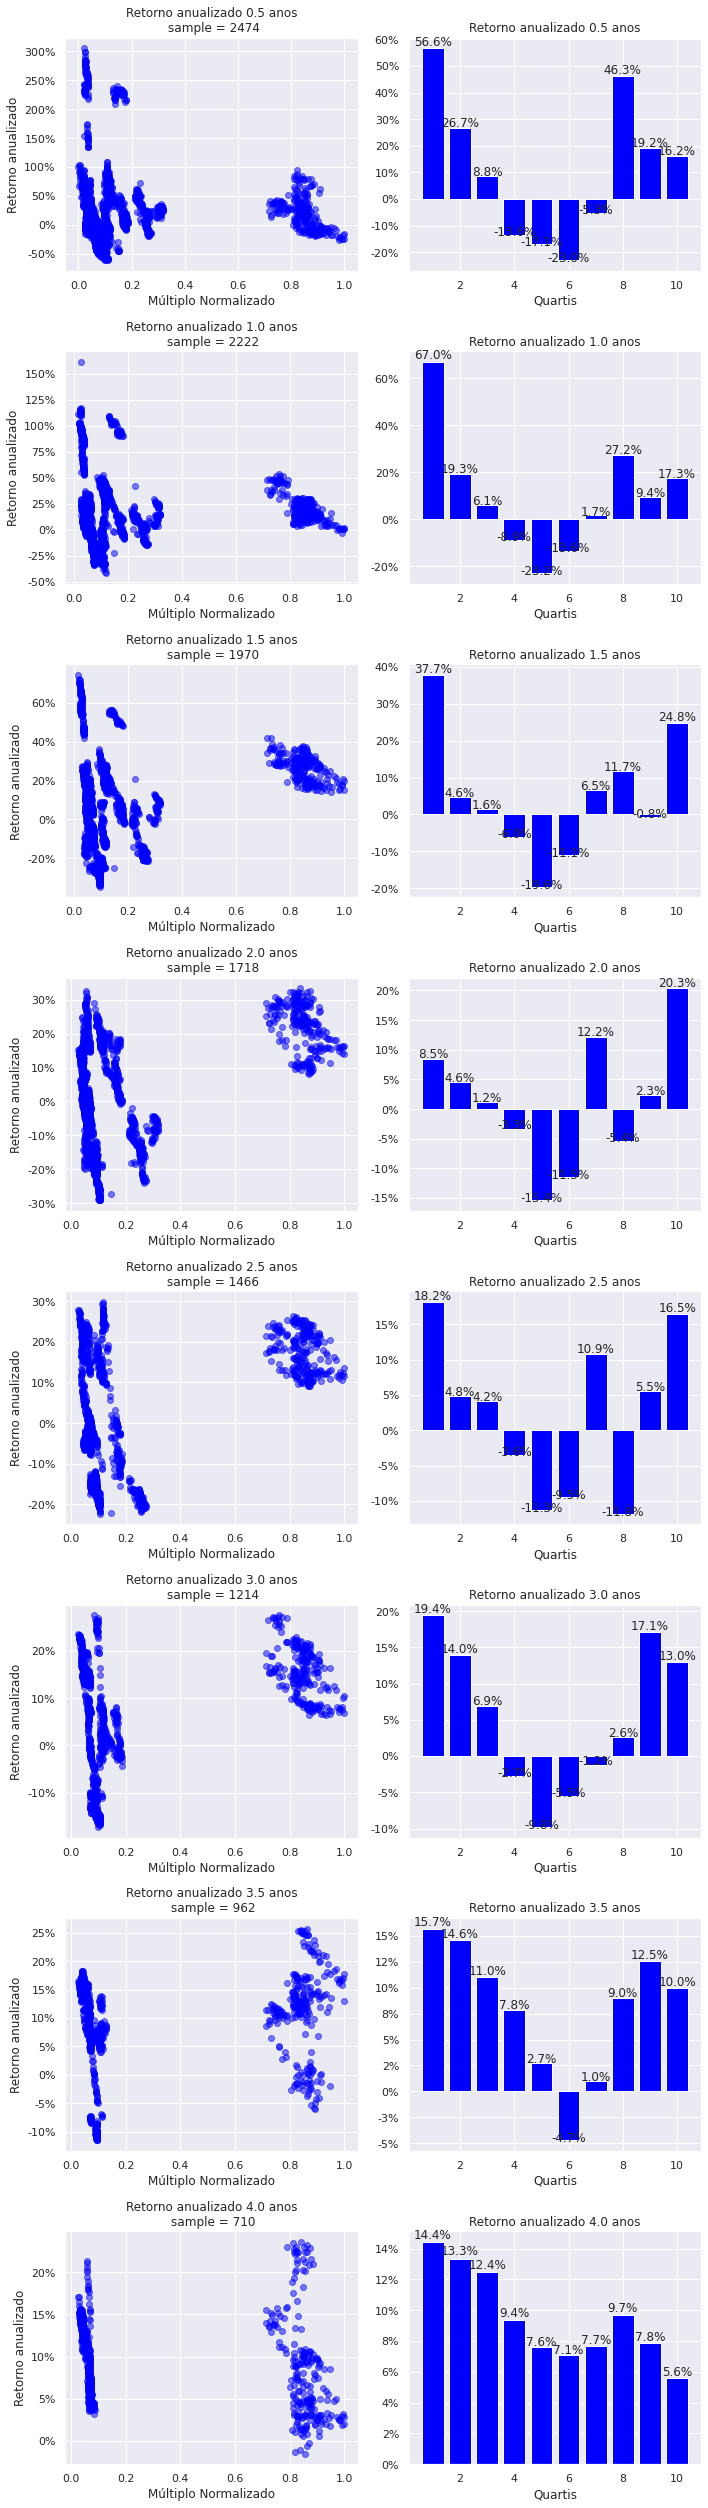

In [ ]:
#5 maiores ações do ibovespa
tickers_cias = ['vale3.sa','petr4.sa','itub4.sa','bbdc4.sa','b3sa3.sa','abev3.sa']
nomes_cias = ['VALE S.A.','PETROLEO BRASILEIRO S.A. PETROBRAS','ITAU UNIBANCO HOLDING S.A.','BCO BRADESCO S.A.','B3 S.A. - BRASIL, BOLSA, BALCÃO','COMPANHIA DE BEBIDAS DAS AMÉRICAS-AMBEV']
#empresa setor auto
tickers_cias = ['mypk3.sa','tupy3.sa','leve3.sa','fras3.sa','pomo4.sa']
nomes_cias = ['IOCHPE MAXION S.A.','TUPY S.A.','MAHLE-METAL LEVE S.A.','FRAS-LE S.A.','MARCOPOLO S.A.']

#tickers_cias = ['cgra4.sa']
#nomes_cias = ['GRAZZIOTIN S.A.']

numero_empresas = len(nomes_cias)
df_carteira = pd.DataFrame()
#loop sobre todas empresas
for i in range (0, numero_empresas):
  #importando a informação dos demonstrativos financeiros de cada empresa
  dre_empresa = filtro_empresa(demonstrativo = dre, nome_cia = nomes_cias[i])
  dmpl_empresa = filtro_empresa(demonstrativo = dmpl, nome_cia = nomes_cias[i])
  #coletando os dados relevantes de cada demonstrativo
  df_receita = coleta_conta(cd_conta = '3.01', demonstrativo = dre_empresa)
  df_pat_liq = coleta_conta(cd_conta = '5.01', demonstrativo = dmpl_empresa)
  df_ebit = coleta_conta(cd_conta = '3.05', demonstrativo = dre_empresa)
  df_lpa = coleta_conta(cd_conta = '3.99.01.01', demonstrativo = dre_empresa)
  df_lucro = coleta_conta(cd_conta = '3.11', demonstrativo = dre_empresa)
  df_lpa = df_lpa.iloc[1:]
  #coluna 0 (cotacoes de cada ativo)
  df_carteira[[nomes_cias[i]]] = cotacoes(start = '2010-01-01', end = '2021-01-01', ticker_cia=tickers_cias[i], interval='1d', nome_cia = nomes_cias[i])
  #coluna 1(retorno diario)
  df_carteira[nomes_cias[i]+'_retorno'] = df_carteira[nomes_cias[i]].pct_change()
  df_carteira[nomes_cias[i]+'_retorno'].iloc[0]=0
  #coluna 2(preço da ação/receita total)
  df_carteira[nomes_cias[i]+'_preco/receita'] = multiplo(df_receita,'receita', df_carteira[[nomes_cias[i]]],nomes_cias[i])
  #coluna 3(preço da ação/patrimonio liquido total)
  #df[nomes_cias[i]+'_preco/pat_liq'] = multiplo(df = df_pat_liq, name = 'pat_liq', ativo = df_carteira[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  #coluna 4(preço da ação/ebit total)
  df_carteira[nomes_cias[i]+'_preco/ebit'] = multiplo(df_ebit, name = 'ebit', ativo = df_carteira[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  #coluna 5(preco/lucro)
  #df[nomes_cias[i]+'_preco/lpa'] = multiplo(df = df_lpa, name = 'lpa', ativo = df_carteira[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  
  numero_colunas = len(df_carteira.columns)
  step = numero_colunas/numero_empresas
  #Definição da variavel carteira_con, que consolida os dados da carteira
  carteira_con = pd.DataFrame()
  carteira_con['preco/receita'] = df_carteira.iloc[:,np.arange(2,df_carteira.shape[1],step = step)].mean(axis=1)
  #carteira_con['preco/pat_liq'] = df_carteira.iloc[:,np.arange(3,df_carteira.shape[1],step = step)].mean(axis=1)
  carteira_con['preco/ebit'] = df_carteira.iloc[:,np.arange(3,df_carteira.shape[1],step = step)].mean(axis=1)
  #carteira_con['preco/lpa'] = df_carteira.iloc[:,np.arange(4,df_carteira.shape[1],step = step)].mean(axis=1)

sns.set()
rows = 2; cols = 8;
fig, axs = plt.subplots(cols, rows, figsize=(10,35), facecolor='w', edgecolor='k')
anos = 0
carteira_con = normalize(carteira_con)
for index in range(0,cols):
  anos = anos+0.5
  retornos = pd.DataFrame()
  for i in range (0, numero_empresas):
    #1 ano são aproximadamente 252 dias de negociação na bolsa
    window = int(anos*252)  
    #coluna 7(retorno acumulado que dará nos proximos n dias, sendo n = window)
    retornos[nomes_cias[i]+'_retorno_acumulado'] = (1+df_carteira[nomes_cias[i]+'_retorno']).shift(-window).rolling(window).apply(np.prod)
  retornos['retorno_acumulado'] = retornos.mean(axis=1)
  retornos['retorno_acumulado_anualizado'] = retornos['retorno_acumulado']**(1/anos)
  carteira_con['retorno_acumulado_anualizado'] = retornos['retorno_acumulado_anualizado']
  axs[index,0].scatter(y = carteira_con['retorno_acumulado_anualizado']-1,x = carteira_con['std_preco/ebit'], marker='o', color='blue', label = 'preco/ebit',alpha =0.5)
  #axs[index,0].scatter(y = carteira_con['retorno_acumulado_anualizado']-1,x =  carteira_con['std_preco/receita'], marker='o', color='r', label = 'Preco/receita', alpha =0.5)
  axs[index,0].title.set_text('Retorno anualizado {} anos\n sample = {}'.format(anos,carteira_con['retorno_acumulado_anualizado'].count()))
  axs[index,1].title.set_text('Retorno anualizado {} anos'.format(anos))
  axs[index,0].set_xlabel("Múltiplo Normalizado")
  axs[index,1].set_xlabel("Quartis")
  axs[index,0].set_ylabel("Retorno anualizado")
  axs[index,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
  axs[index,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
  list1,list2 = quartiles(10,carteira_con,'std_preco/ebit')
  axs[index,1].bar(list2,list1, color = 'blue')
  #https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
  for p in axs[index,1].patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axs[index,1].annotate(f"{height:.1%}", (x + width/2, y + height*1.02), ha='center')
fig.tight_layout()

Quais multiplos são mais relevantes?

In [ ]:
#5 maiores ações do ibovespa
tickers_cias = ['vale3.sa','petr4.sa','itub4.sa','bbdc4.sa','b3sa3.sa','abev3.sa']
nomes_cias = ['VALE S.A.','PETROLEO BRASILEIRO S.A. PETROBRAS','ITAU UNIBANCO HOLDING S.A.','BCO BRADESCO S.A.','B3 S.A. - BRASIL, BOLSA, BALCÃO','COMPANHIA DE BEBIDAS DAS AMÉRICAS-AMBEV']
#empresa setor auto
#tickers_cias = ['mypk3.sa','tupy3.sa','leve3.sa','fras3.sa','pomo4.sa']
#nomes_cias = ['IOCHPE MAXION S.A.','TUPY S.A.','MAHLE-METAL LEVE S.A.','FRAS-LE S.A.','MARCOPOLO S.A.']

#tickers_cias = ['cgra4.sa']
#nomes_cias = ['GRAZZIOTIN S.A.']

numero_empresas = len(nomes_cias)
df_carteira = pd.DataFrame()
#loop sobre todas empresas
for i in range (0, numero_empresas):
  #importando a informação dos demonstrativos financeiros de cada empresa
  dre_empresa = filtro_empresa(demonstrativo = dre, nome_cia = nomes_cias[i])
  dmpl_empresa = filtro_empresa(demonstrativo = dmpl, nome_cia = nomes_cias[i])
  #coletando os dados relevantes de cada demonstrativo
  df_receita = coleta_conta(cd_conta = '3.01', demonstrativo = dre_empresa)
  df_pat_liq = coleta_conta(cd_conta = '5.01', demonstrativo = dmpl_empresa)
  df_ebit = coleta_conta(cd_conta = '3.05', demonstrativo = dre_empresa)
  df_lpa = coleta_conta(cd_conta = '3.99.01.01', demonstrativo = dre_empresa)
  df_lucro = coleta_conta(cd_conta = '3.11', demonstrativo = dre_empresa)
  df_lpa = df_lpa.iloc[1:]
  #coluna 0 (cotacoes de cada ativo)
  df_carteira[[nomes_cias[i]]] = cotacoes(start = '2010-01-01', end = '2021-01-01', ticker_cia=tickers_cias[i], interval='1d', nome_cia = nomes_cias[i])
  #coluna 1(retorno diario)
  df_carteira[nomes_cias[i]+'_retorno'] = df_carteira[nomes_cias[i]].pct_change()
  df_carteira[nomes_cias[i]+'_retorno'].iloc[0]=0
  #coluna 2(preço da ação/receita total)
  df_carteira[nomes_cias[i]+'_preco/receita'] = multiplo(df_receita,'receita', df_carteira[[nomes_cias[i]]],nomes_cias[i])
  #coluna 3(preço da ação/patrimonio liquido total)
  #df[nomes_cias[i]+'_preco/pat_liq'] = multiplo(df = df_pat_liq, name = 'pat_liq', ativo = df_carteira[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  #coluna 4(preço da ação/ebit total)
  df_carteira[nomes_cias[i]+'_preco/ebit'] = multiplo(df_ebit, name = 'ebit', ativo = df_carteira[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  #coluna 5(preco/lucro)
  #df[nomes_cias[i]+'_preco/lpa'] = multiplo(df = df_lpa, name = 'lpa', ativo = df_carteira[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  
  numero_colunas = len(df_carteira.columns)
  step = numero_colunas/numero_empresas
  #Definição da variavel carteira_con, que consolida os dados da carteira
  carteira_con = pd.DataFrame()
  carteira_con['preco/receita'] = df_carteira.iloc[:,np.arange(2,df_carteira.shape[1],step = step)].mean(axis=1)
  #carteira_con['preco/pat_liq'] = df_carteira.iloc[:,np.arange(3,df_carteira.shape[1],step = step)].mean(axis=1)
  carteira_con['preco/ebit'] = df_carteira.iloc[:,np.arange(3,df_carteira.shape[1],step = step)].mean(axis=1)
  #carteira_con['preco/lpa'] = df_carteira.iloc[:,np.arange(4,df_carteira.shape[1],step = step)].mean(axis=1)

anos = 4
carteira_con = normalize(carteira_con)
retornos = pd.DataFrame()
for i in range (0, numero_empresas):
  #1 ano são aproximadamente 252 dias de negociação na bolsa
  window = int(anos*252)  
  #coluna 7(retorno acumulado que dará nos proximos n dias, sendo n = window)
  retornos[nomes_cias[i]+'_retorno_acumulado'] = (1+df_carteira[nomes_cias[i]+'_retorno']).shift(-window).rolling(window).apply(np.prod)
retornos['retorno_acumulado'] = retornos.mean(axis=1)
retornos['retorno_acumulado_anualizado'] = retornos['retorno_acumulado']**(1/anos)
carteira_con['retorno_acumulado_anualizado'] = retornos['retorno_acumulado_anualizado']
carteira_con.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
X =carteira_con.iloc[:, 2:4].values
y = carteira_con.iloc[:,4].values

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 0)
regressor = DecisionTreeRegressor(max_depth=2)
regressor.fit(X_treinamento, y_treinamento)
score = regressor.score(X_treinamento, y_treinamento)

previsoes = regressor.predict(X_teste)
mae = mean_absolute_error(y_teste, previsoes)

print("score: {} \n".format(regressor.score(X_teste, y_teste)))
print('MAE: {} \n'.format(mae))
print(regressor.feature_importances_,"\n")
print(carteira_con.iloc[:, 2:4].columns)

score: 0.16244785410185458 

MAE: 0.046767175570956734 

[0. 1.] 

Index(['std_preco/ebit', 'std_preco/receita'], dtype='object')


In [ ]:
export.export_graphviz(regressor,
                       out_file = 'arvore.dot',
                       feature_names = ['std_preco/pat_liq', 'std_preco/ebit','std_preco/receita'],
                       class_names = regressor.classes_,
                       filled = True,
                       leaves_parallel=True)